In [1]:
import tarfile
from itertools import groupby
from zlib import decompress
import functools

import numpy as np
import zstandard

In [2]:
import os
from pathlib import Path

In [3]:
from datetime import datetime
import polars as pl

In [4]:
metadata = pl.read_csv('raw/metadata.csv', try_parse_dates=True)
metadata

user,start_date,end_date,length_days,length_years,potential_samples,actual_samples,missing_samples_abs,missing_samples_pct,contract_start_date,contract_end_date,contracted_tariff,self_consumption_type,p1,p2,p3,p4,p5,p6,province,municipality,zip_code,cnae
str,"datetime[μs, UTC]","datetime[μs, UTC]",f64,f64,i64,i64,i64,f64,date,date,str,str,f64,f64,f64,f64,f64,f64,str,str,i64,i64
"""00000c5a448d9faa097b761cc98036…",2022-05-30 01:00:00 UTC,2022-06-05 00:00:00 UTC,6.0,0.016427,144,144,0,0.0,2022-05-31,null,"""2.0TD""","""""",2.2,2.2,0.0,0.0,0.0,0.0,"""Gipuzkoa""",null,null,9329
"""0001b3b2f18c01c62ed9b2a87de7b4…",2017-05-31 01:00:00 UTC,2022-06-05 00:00:00 UTC,1831.0,5.013005,43944,43863,81,0.184326,2021-06-01,null,"""2.0TD""","""""",3.45,3.45,null,null,null,null,"""Bizkaia""",null,null,9820
"""0003de2700e20a1681d69fe287441d…",2017-05-31 01:00:00 UTC,2019-11-14 00:00:00 UTC,897.0,2.455852,21528,21476,52,0.241546,2019-09-02,2019-11-13,"""2.0A""","""""",4.6,null,null,null,null,null,"""Gipuzkoa""","""Donostia/San Sebastian""",20013,9820
"""0004150214d14a2b2e6f7075531e66…",2018-07-12 01:00:00 UTC,2022-06-05 00:00:00 UTC,1424.0,3.8987,34176,34169,7,0.020482,2021-06-01,null,"""2.0TD""","""""",9.2,9.2,null,null,null,null,"""Gipuzkoa""","""Irun""",20304,4759
"""000721f0fc6ccf02ae24b673939795…",2017-05-30 01:00:00 UTC,2022-06-04 00:00:00 UTC,1831.0,5.013005,43944,43815,129,0.293555,2021-06-01,null,"""2.0TD""","""""",4.4,4.4,null,null,null,null,"""Bizkaia""",null,null,9820
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ffeddf4919e748beb50af7c6b73def…",2018-10-02 01:00:00 UTC,2021-11-03 00:00:00 UTC,1128.0,3.088296,27072,27069,3,0.011082,2021-06-01,null,"""2.0TD""","""""",6.0,6.0,null,null,null,null,"""Soria""",null,null,9820
"""ffefb9e27715b1c3fa5007c457de55…",2021-07-06 01:00:00 UTC,2022-06-05 00:00:00 UTC,334.0,0.914442,8016,8014,2,0.02495,2021-07-07,null,"""2.0TD""","""""",3.45,3.45,0.0,0.0,0.0,0.0,"""Bizkaia""","""Bilbao""",48012,9820
"""fff0adcd6cdb7434496a5222f03337…",2017-08-17 01:00:00 UTC,2022-06-05 00:00:00 UTC,1753.0,4.799452,42072,41102,970,2.305571,2021-06-01,null,"""2.0TD""","""""",4.6,4.6,null,null,null,null,"""Bizkaia""",null,null,9820


In [ ]:
metadata.group_by()

In [5]:
# metadata['start_date'] = pl.date(metadata['start_date'])
# metadata['end_date'] = pl.datetime(metadata['end_date'])

In [22]:
# metadata_post_covid = metadata[metadata['start_date'] > pd.to_datetime('2021-05-31T00:00:00Z')]
metadata_post_covid = metadata.filter(
    pl.col("end_date").is_between(pl.datetime(2021, 5, 31, time_zone="UTC"), pl.datetime(2021, 1, 1, time_zone="UTC"))
)
metadata_post_covid.head()

user,start_date,end_date,length_days,length_years,potential_samples,actual_samples,missing_samples_abs,missing_samples_pct,contract_start_date,contract_end_date,contracted_tariff,self_consumption_type,p1,p2,p3,p4,p5,p6,province,municipality,zip_code,cnae
str,"datetime[μs, UTC]","datetime[μs, UTC]",f64,f64,i64,i64,i64,f64,date,date,str,str,f64,f64,f64,f64,f64,f64,str,str,i64,i64
"""00000c5a448d9faa097b761cc98036…",2022-05-30 01:00:00 UTC,2022-06-05 00:00:00 UTC,6.0,0.016427,144,144,0,0.0,2022-05-31,null,"""2.0TD""","""""",2.2,2.2,0.0,0.0,0.0,0.0,"""Gipuzkoa""",null,null,9329
"""0001b3b2f18c01c62ed9b2a87de7b4…",2017-05-31 01:00:00 UTC,2022-06-05 00:00:00 UTC,1831.0,5.013005,43944,43863,81,0.184326,2021-06-01,null,"""2.0TD""","""""",3.45,3.45,null,null,null,null,"""Bizkaia""",null,null,9820
"""0004150214d14a2b2e6f7075531e66…",2018-07-12 01:00:00 UTC,2022-06-05 00:00:00 UTC,1424.0,3.8987,34176,34169,7,0.020482,2021-06-01,null,"""2.0TD""","""""",9.2,9.2,null,null,null,null,"""Gipuzkoa""","""Irun""",20304,4759
"""000721f0fc6ccf02ae24b673939795…",2017-05-30 01:00:00 UTC,2022-06-04 00:00:00 UTC,1831.0,5.013005,43944,43815,129,0.293555,2021-06-01,null,"""2.0TD""","""""",4.4,4.4,null,null,null,null,"""Bizkaia""",null,null,9820
"""0009b156f2a1213a137c150f478715…",2017-12-11 01:00:00 UTC,2022-06-04 00:00:00 UTC,1636.0,4.479124,39264,39255,9,0.022922,2021-06-01,null,"""2.0TD""","""""",3.45,3.45,null,null,null,null,"""Gipuzkoa""",null,null,9820


In [7]:
metadata_post_covid['user'].unique()

user
str
"""1248632826b673ad4ade58609d9ca8…"
"""66da095257e8b370f84c2d56efc406…"
"""c2c70b74bedd921b5356d1157b742f…"
"""e9160ee5e9cd6721f56e8b4b1476d5…"
"""126c065f4f763b7b56cc33503e0edb…"
…
"""98cc9f1de0f82d41e97f834ad8692f…"
"""ba34fb335aec20e576627fe98713a7…"
"""d81b9bf50682c049fcf72914ef5c6c…"


In [8]:
metadata_post_covid['municipality'].value_counts()

municipality,count
str,u32
"""Valladolid""",1
"""Parla""",1
"""Madrid""",178
"""Cuenca""",1
"""Getxo""",42
…,…
"""Arganda del Rey""",1
"""Linares""",1
"""Pinto""",1


In [9]:
metadata_post_covid.filter(metadata_post_covid['province'].is_not_null())

user,start_date,end_date,length_days,length_years,potential_samples,actual_samples,missing_samples_abs,missing_samples_pct,contract_start_date,contract_end_date,contracted_tariff,self_consumption_type,p1,p2,p3,p4,p5,p6,province,municipality,zip_code,cnae
str,"datetime[μs, UTC]","datetime[μs, UTC]",f64,f64,i64,i64,i64,f64,date,date,str,str,f64,f64,f64,f64,f64,f64,str,str,i64,i64
"""00000c5a448d9faa097b761cc98036…",2022-05-30 01:00:00 UTC,2022-06-05 00:00:00 UTC,6.0,0.016427,144,144,0,0.0,2022-05-31,null,"""2.0TD""","""""",2.2,2.2,0.0,0.0,0.0,0.0,"""Gipuzkoa""",null,null,9329
"""001969772145e8c6bb738528594aef…",2021-12-14 01:00:00 UTC,2022-06-05 00:00:00 UTC,173.0,0.473648,4152,4151,1,0.024085,2021-12-15,null,"""2.0TD""","""""",4.4,4.4,0.0,0.0,0.0,0.0,"""Bizkaia""","""Bilbao""",48013,null
"""001e11d0fbe42f2b119741d5af6f4a…",2021-07-30 01:00:00 UTC,2022-06-04 00:00:00 UTC,309.0,0.845996,7416,7414,2,0.026969,2021-07-31,null,"""2.0TD""","""""",5.75,5.75,0.0,0.0,0.0,0.0,"""Araba/Alava""","""Vitoria-Gasteiz""",1015,9820
"""0024e07345b50dd266c6390d5c496a…",2021-06-03 01:00:00 UTC,2022-06-05 00:00:00 UTC,367.0,1.004791,8808,8806,2,0.022707,2021-06-04,null,"""2.0TD""","""""",4.4,4.4,0.0,0.0,0.0,0.0,"""Navarra""",null,null,9820
"""00286b6d86e8094a80c6efeec03c55…",2021-09-01 01:00:00 UTC,2022-06-05 00:00:00 UTC,277.0,0.758385,6648,6646,2,0.030084,2021-09-02,null,"""2.0TD""","""""",3.45,3.45,0.0,0.0,0.0,0.0,"""Gipuzkoa""",null,null,9820
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ffe0fec04b184324aaef086e779326…",2021-12-31 01:00:00 UTC,2022-06-05 00:00:00 UTC,156.0,0.427105,3744,3743,1,0.026709,2022-01-01,null,"""2.0TD""","""""",3.3,3.3,null,null,null,null,"""Gipuzkoa""",null,null,9820
"""ffe139ac875ad687fa4f02fad29f12…",2021-09-17 01:00:00 UTC,2022-03-05 00:00:00 UTC,169.0,0.462697,4056,4055,1,0.024655,2021-09-18,null,"""2.0TD""","""""",2.2,2.2,0.0,0.0,0.0,0.0,"""Araba/Alava""",null,null,0
"""ffefb9e27715b1c3fa5007c457de55…",2021-07-06 01:00:00 UTC,2022-06-05 00:00:00 UTC,334.0,0.914442,8016,8014,2,0.02495,2021-07-07,null,"""2.0TD""","""""",3.45,3.45,0.0,0.0,0.0,0.0,"""Bizkaia""","""Bilbao""",48012,9820


In [10]:
def getUniqueCount(df:pl.DataFrame, group_by:str):
    return df.group_by(group_by).len().sort('len', descending=True)

In [11]:
getUniqueCount(metadata_post_covid, 'cnae')

cnae,len
i64,u32
9820,3289
null,176
8411,158
5210,119
9810,109
…,…
170,1
4799,1
2341,1


# PLOTS

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt



In [10]:
df = pl.read_csv('dataset/goi4_pst/imp_csv/9d8f82f21c8e09dba6531395dac2bd59c2d11b612a23e27708764830bf966c9f.csv', try_parse_dates=True, schema_overrides={'kWh':pl.Float64})
df.head()

timestamp,kWh,imputed
datetime[μs],f64,i64
2021-05-31 00:00:00,0.0,0
2021-05-31 01:00:00,0.0,0
2021-05-31 02:00:00,0.0,0
2021-05-31 03:00:00,0.0,0
2021-05-31 04:00:00,0.0,0


In [11]:
def avg(df:pl.DataFrame, time_col = 'timestamp', value_col = 'kWh', period='1mo'):
    df_avg_m = df.group_by_dynamic(time_col, every=period, period=period, closed='left').agg(
        pl.col(value_col).mean()
    )
    return df_avg_m

def plot(df:pl.DataFrame, time_col='timestamp', value_col='kWh', color_col='profile_id'):
    sns.relplot(
        data=df, kind="line",
        hue=color_col,
        x=time_col, y=value_col)

def avg_plot(df:pl.DataFrame, time_col = 'timestamp', value_col = 'kWh', period='1mo',  color_col='profile_id',):
    df_avg_m = df.group_by_dynamic(time_col, every=period, period=period, closed='left').agg(
        pl.col(value_col).mean()
    )
    sns.relplot(
        data=df_avg_m, kind="line",
        hue=color_col,
        x=time_col, y=value_col)

    return df_avg_m

timestamp,kWh
datetime[μs],f64
2021-05-01 00:00:00,0.0
2021-06-01 00:00:00,0.0
2021-07-01 00:00:00,0.0
2021-08-01 00:00:00,0.0
2021-09-01 00:00:00,0.0892875
…,…
2022-02-01 00:00:00,0.16494
2022-03-01 00:00:00,0.176119
2022-04-01 00:00:00,0.145157


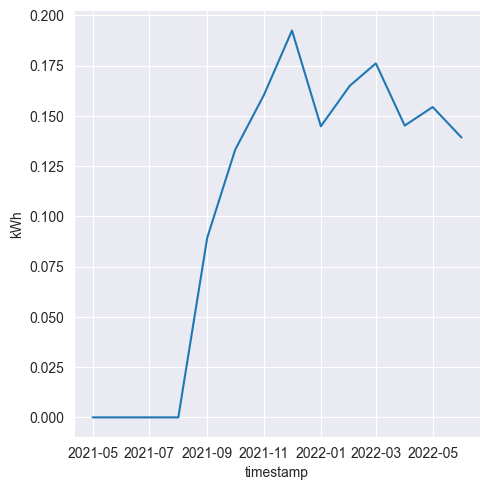

In [12]:
avg_plot(df, color_col=None)

# LIST OF HOUSEHOLD PROFILES

T - 97XX-98XX Activities of households

https://www.nature.com/articles/s41597-023-02846-0/tables/1

In [23]:
_filter =  (pl.col('length_years') >= 1.0)

metadata_post_activities = metadata_post_covid.filter(_filter)
profiles = metadata_post_activities['user'].unique().to_list()
len(profiles)

19403

In [24]:
len(metadata_post_covid['user'].unique().to_list())

23970

In [13]:
# filter = (pl.col('cnae') > 9699) & (pl.col('cnae') < 9849) & (pl.col('length_years') >= .50)
# filter = (pl.col('cnae') > 9699) & (pl.col('cnae') < 9849)
filter =  (pl.col('length_years') >= 1.0)

metadata_post_household_activities = metadata_post_covid.filter(filter)
household_profiles = metadata_post_household_activities['user'].unique().to_list()
len(household_profiles)a

120

In [89]:
household_stats = metadata_post_household_activities.describe()
min_days_household_stat = int(household_stats.filter(pl.col('statistic') == "min")['length_days'][0])
max_days_household_stat = int(household_stats.filter(pl.col('statistic') == "max")['length_days'][0])

In [112]:
range_min_max_household_stat = range(min_days_household_stat, max_days_household_stat)

post_household_users_length_days_cum = [len(metadata_post_household_activities.filter(pl.col('length_days') >= n_day)['user'].unique().to_list())  for n_day in range_min_max_household_stat]
post_users_length_days_cum = [len(metadata_post_covid.filter(pl.col('length_days') >= n_day)['user'].unique().to_list())  for n_day in range_min_max_household_stat]
users_length_days_cum = [len(metadata.filter(pl.col('length_days') >= n_day)['user'].unique().to_list())  for n_day in range_min_max_household_stat]


In [114]:
df_n_users = pl.DataFrame({
    "Min days present": range_min_max_household_stat,
    "# users (post-COVID, household)": post_household_users_length_days_cum,
    "# users (post-COVID)": post_users_length_days_cum,
    "# users (all)": users_length_days_cum,
})

In [116]:
df_n_users.head()

Min days present,"# users (post-COVID, household)",# users (post-COVID),# users (all)
i64,i64,i64,i64
1,3485,4436,25559
2,3484,4434,25553
3,3470,4416,25532
4,3455,4398,25509
5,3444,4379,25486


In [126]:
dfm = df_n_users.unpivot(index = df_n_users.columns[0], variable_name='cols', value_name='# users')
dfm

Min days present,cols,# users
i64,str,i64
1,"""# users (post-COVID, household…",3485
2,"""# users (post-COVID, household…",3484
3,"""# users (post-COVID, household…",3470
4,"""# users (post-COVID, household…",3455
5,"""# users (post-COVID, household…",3444
…,…,…
364,"""# users (all)""",20442
365,"""# users (all)""",20438
366,"""# users (all)""",20420


Text(0.5, 1.0, 'Number of users available')

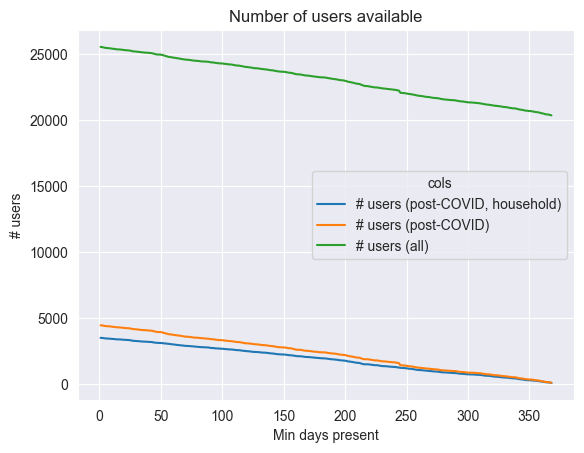

In [128]:
p = sns.lineplot(data = dfm,
             x = dfm.columns[0], y= dfm.columns[-1], hue='cols')
p.set_title("Number of users available")

# COMBINE

In [14]:
import glob

In [15]:
source_folder = 'dataset/goi4_pst/imp_csv'
csv_files = glob.glob(f"{source_folder}/*.csv")

In [ ]:
df_household_activities = metadata_post_covid.filter(filter)
household_profiles = df_household_activities['user'].unique().to_list()
len(household_profiles)

In [16]:
dataframes = pl.DataFrame()
for csv_file in csv_files:
    # print(f"processing {csv_file}")
    profile_id = csv_file.split('/')[-1].split('.')[0]
    if profile_id not in household_profiles:
        # print(f"skipping {csv_file}")
        continue

    df = pl.read_csv(csv_file, try_parse_dates=True, schema_overrides={'kWh':pl.Float64})
    # print(df.head())
    df = df.with_columns(pl.lit(profile_id).alias('profile_id'))
    if not dataframes.columns:
        dataframes = df.clone()
        continue
    dataframes.extend(df)

dataframes.head()

timestamp,kWh,imputed,profile_id
datetime[μs],f64,i64,str
2021-05-31 00:00:00,0.133,0,"""e09da31b7a07f3f97c51c78dea39f9…"
2021-05-31 01:00:00,0.125,0,"""e09da31b7a07f3f97c51c78dea39f9…"
2021-05-31 02:00:00,0.184,0,"""e09da31b7a07f3f97c51c78dea39f9…"
2021-05-31 03:00:00,0.137,0,"""e09da31b7a07f3f97c51c78dea39f9…"
2021-05-31 04:00:00,0.111,0,"""e09da31b7a07f3f97c51c78dea39f9…"


In [86]:
dataframes.write_csv("dataset/goi4_pst/household_activities_all.csv")

In [17]:
df_avg = dataframes.group_by_dynamic('timestamp', group_by= 'profile_id', every='1mo', period='1mo', closed='right').agg(
        pl.col('kWh').mean()
    )
df_avg.head()


profile_id,timestamp,kWh
str,datetime[μs],f64
"""0001b3b2f18c01c62ed9b2a87de7b4…",2021-05-01 00:00:00,0.17752
"""0001b3b2f18c01c62ed9b2a87de7b4…",2021-06-01 00:00:00,0.178035
"""0001b3b2f18c01c62ed9b2a87de7b4…",2021-07-01 00:00:00,0.12687
"""0001b3b2f18c01c62ed9b2a87de7b4…",2021-08-01 00:00:00,0.129126
"""0001b3b2f18c01c62ed9b2a87de7b4…",2021-09-01 00:00:00,0.143267


In [56]:
_df = dataframes.filter((pl.col('profile_id').str.starts_with('50')))
_df

timestamp,kWh,imputed,profile_id
datetime[μs],f64,i64,str
2021-05-31 00:00:00,0.344,0,"""50763044cb11d4c00dea544f8c418e…"
2021-05-31 01:00:00,0.11,0,"""50763044cb11d4c00dea544f8c418e…"
2021-05-31 02:00:00,0.106,0,"""50763044cb11d4c00dea544f8c418e…"
2021-05-31 03:00:00,0.082,0,"""50763044cb11d4c00dea544f8c418e…"
2021-05-31 04:00:00,0.133,0,"""50763044cb11d4c00dea544f8c418e…"
…,…,…,…
2022-06-04 20:00:00,0.044,0,"""50da64c7686a499cab8342c724e57b…"
2022-06-04 21:00:00,0.086,0,"""50da64c7686a499cab8342c724e57b…"
2022-06-04 22:00:00,0.075,0,"""50da64c7686a499cab8342c724e57b…"


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.ObjectDType'>)

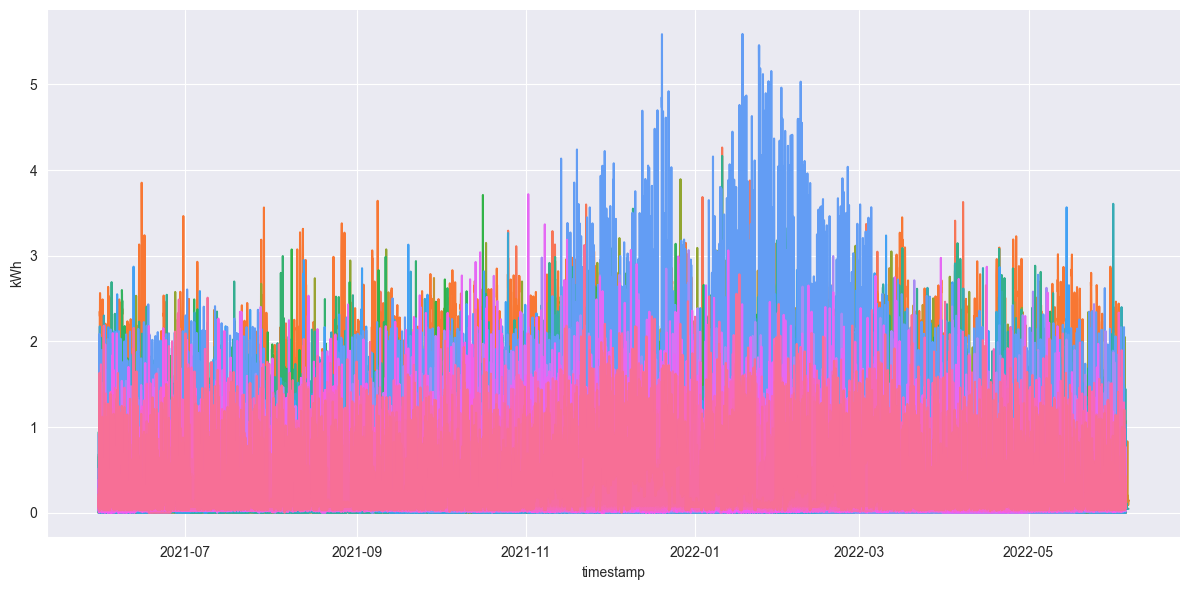

In [57]:
sns.relplot(
    data=_df, kind="line",
    hue='profile_id', legend=False,
    x='timestamp', y='kWh',
    height=6, aspect=2,
    )


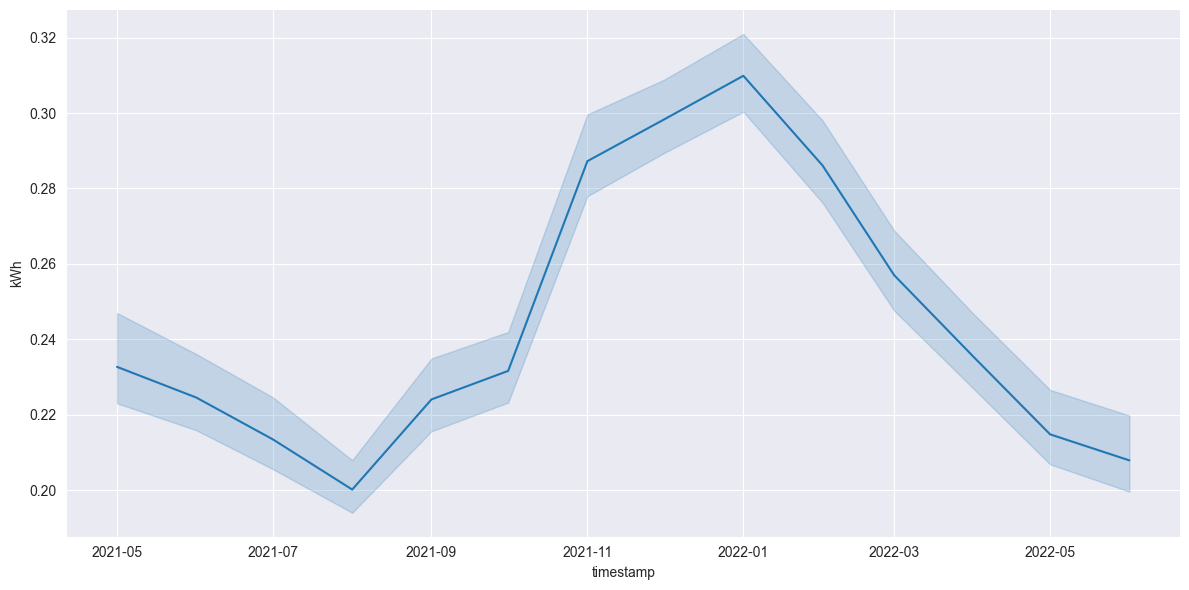

In [55]:
sns.relplot(
    data=dataframes, kind="line",
    legend=False,
    x='timestamp', y='kWh',
    height=6, aspect=2,
    )


# COMBINE CSV USELESS

In [14]:
import glob
import pandas as pd

def combine_csv_files(source_folder, output_file):
    # Get a list of all .csv files in the source folder
    csv_files = glob.glob(f"{source_folder}/*.csv")

    # Create an empty list to store dataframes
    dataframes = []

    # Loop through each .csv file, read it, and append it to the list of dataframes
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dataframes.append(df)

    # Concatenate all dataframes into one
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Save the combined dataframe to a new .csv file
    combined_df.to_csv(output_file, index=False)
    print(f"Combined CSV saved to {output_file}")


In [15]:
combine_csv_files("dataset/goi4_pst/imp_csv", "output.csv")

Combined CSV saved to output


In [17]:
import csv

def combine_csv_files(source_folder, output_file):
    # Get a list of all .csv files in the source folder
    csv_files = glob.glob(f"{source_folder}/*.csv")

    # Open the output file in write mode
    with open(output_file, mode='w', newline='') as outfile:
        writer = csv.writer(outfile)

        # Variable to track if headers have been written
        headers_written = False

        # Loop through each .csv file
        for file_path in csv_files:

            # Open each CSV file in read mode
            with open(file_path, mode='r', newline='') as infile:
                reader = csv.reader(infile)

                # Write headers only once
                if not headers_written:
                    headers = next(reader)  # Read the header of the first file
                    writer.writerow(headers)  # Write the header to the output file
                    headers_written = True
                else:
                    next(reader)  # Skip the header of subsequent files

                # Write the data rows to the output file
                for row in reader:
                    writer.writerow(row)


combine_csv_files("dataset/goi4_pst/imp_csv", "output.csv")